In [3]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np                         # Good module for matrix and matrix operation
import matplotlib.pyplot as plt            # Module to produce figure
import matplotlib.colors as colors
import os                                  # Used to convert png to other format
from matplotlib.path import Path
import matplotlib.patches as patches
import netCDF4
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import numpy as np

In [4]:
def lambert_map(extent=(-82, -75, 41, 46), cent_lon =-80,figsize=(14, 12), fig = None, ax = None):

    proj = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=35,
                                 standard_parallels=[35])
    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1, projection=proj)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='None',
                                            #edgecolor='face',
                                            facecolor='0.9')
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='None',
                                            facecolor=[(0.59375 , 0.71484375, 0.8828125)])
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='k',
                                            facecolor='None',lw=0.8)
    ax.add_feature(land_50m);
    #ax.add_feature(lakes_50m, zorder=3); 
    ax.add_feature(lakes_50m_edge, zorder=10,lw=0.8);
    #ax.add_feature(cfeature.LAKES, edgecolor='white', zorder=10);
    ax.add_feature(cfeature.BORDERS, zorder=10,edgecolor='dimgray');
    #ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    #ax.coastlines('50m', zorder=15, color='k',lw=0.5)
    ax.coastlines('50m', zorder=15, color='k',linewidths=0.8)
    # Set plot bounds
    ax.set_extent(extent)
    return fig, ax

In [5]:
perc ='p99p0'
percentile = 99
totaltx     = 7305*24   #total hourly timesteps from 2001 to 2020
percent_num = int((100.-percentile)/100*(totaltx))

In [6]:
Topo  = netCDF4.Dataset('Geopotential_orography.nc','r')
elevation = Topo.variables['z'][0,:,:]
print(elevation.shape)

Track=netCDF4.Dataset('CompoundExtremes_'+perc+'_ETC_association_relaxto12h_2001_2020_ERA5.nc','r')
lat0 = Track.variables['latitude'][:]
lon0 = Track.variables['longitude'][:]

ETC_counts_12h = Track.variables['ETC_Compound_counts_12h'][:,:,:]
noETC_counts_12h = Track.variables['noETC_Compound_counts_12h'][:,:,:]

total_counts_12h = ETC_counts_12h+noETC_counts_12h

(201, 521)


In [7]:
lon, lat = np.meshgrid(lon0, lat0)
print (lat.shape[0])
print (lon.shape[1])

nx= lon.shape[0]
ny= lon.shape[1]

mask=np.ones((nx,ny),dtype=bool)
maskzero=np.ones((nx,ny))
for i in np.arange(nx):
    for j in np.arange (ny):
        if (lat[i,j]<=60 and lat[i,j]>=40 and lon[i,j]>=255 and lon[i,j]<=300):
        #if (lat[i,j]<=45.4 and lat[i,j]>=45 and lon[i,j]>=286 and lon[i,j]<=286.4):
             mask[i,j] = False
             maskzero[i,j] = 1.

201
521


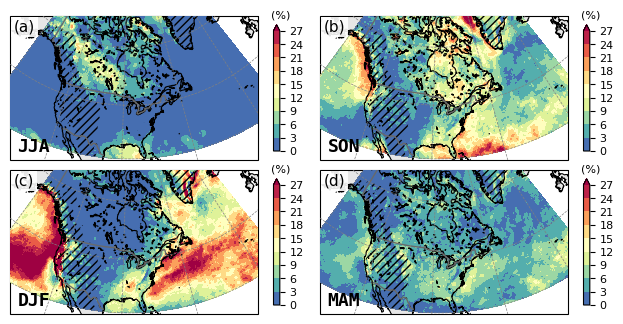

In [8]:
mono_font = {'fontname':'monospace'}
sans_font = {'fontname':'sans-serif'}
season=['JJA','SON','DJF','MAM']
label=['(a)','(b)','(c)','(d)']

fig = plt.figure(figsize=(8,4))
proj = ccrs.LambertConformal(central_longitude=-87, central_latitude=35,
                                 standard_parallels=[35])
levels=np.arange(0,30,3)

for s in range(4):
    ax = fig.add_subplot(2, 2, s+1, projection=proj)
    fig, ax = lambert_map(extent=(-133, -37, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
    cf = ax.contourf(lon, lat, total_counts_12h[s,:,:]/percent_num*100., levels, transform=ccrs.PlateCarree(), zorder=6,
                 cmap=plt.cm.get_cmap('Spectral_r'),extend='max')

    gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

    cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

    gl.top_labels=False 
    gl.bottom_labels=False
    gl.left_labels=False
    gl.right_labels=False

    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
    gl.ylocator = mticker.FixedLocator([25,45,65,85])
    cb = plt.colorbar(cf, shrink=0.82) #, ticks=np.arange(0,3,1))
    cb.ax.tick_params(labelsize=8)
    cb.ax.set_title('(%)',x=1.2, y= 1.04, fontsize=8)
    ax.text(0.03,0.03,''+season[s]+'',horizontalalignment='left',verticalalignment='bottom', 
            transform=ax.transAxes,fontsize=13,zorder=28, **mono_font, weight='bold')

    ax.text(0.015,0.975,''+label[s]+'',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=11,zorder=28,**sans_font)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('FigS4_Frequency_compound_'+perc+'_ERA5', bbox_inches='tight', dpi=200)
plt.show()
#plt.close()

In [9]:
All_Compound_counts_ann = np.sum(total_counts_12h, axis=0)

EXfreq_masked=np.ma.masked_where(mask>=1,All_Compound_counts_ann/percent_num*100.)
EXfreq_subD = np.average(EXfreq_masked)

In [10]:
ETC_Compound_counts_ann = np.sum(ETC_counts_12h, axis=0)

EXfreq_masked=np.ma.masked_where(mask>=1,ETC_Compound_counts_ann)
EXfreq_subD = np.average(EXfreq_masked)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


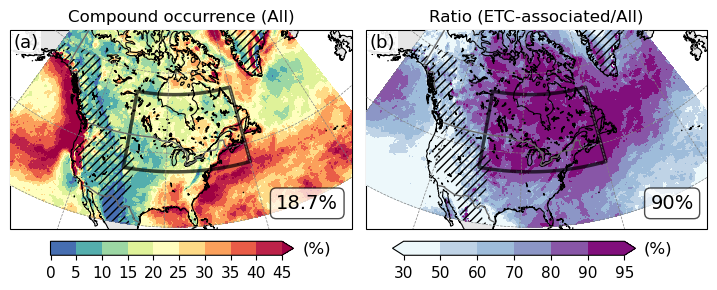

In [11]:
mono_font = {'fontname':'monospace'}
sans_font = {'fontname':'sans-serif'}


fig = plt.figure(figsize=(9,4))
proj = ccrs.LambertConformal(central_longitude=-87, central_latitude=35,
                        standard_parallels=[35])

mono_font = {'fontname':'monospace'}

All_Compound_counts_ann = np.sum(total_counts_12h, axis=0)

CompAll_p99p0_masked=np.ma.masked_where(mask>=1,All_Compound_counts_ann/percent_num*100.)
CompAll_p99p0 = np.average(CompAll_p99p0_masked)



levels=np.arange(0,50,5)


ax = fig.add_subplot(1, 2, 1, projection=proj)
fig, ax = lambert_map(extent=(-133, -37, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
cf = ax.contourf(lon, lat, All_Compound_counts_ann/percent_num*100., levels, transform=ccrs.PlateCarree(), zorder=6,
                 cmap=plt.cm.get_cmap('Spectral_r'),extend='max')

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)

cf2 = ax.contour(lon,lat,mask, transform=ccrs.PlateCarree(), levels=[1],
               colors='k',linewidths=2.5,zorder=7,alpha=0.7)

ax.text(0.96,0.1,''+str('{:3.1f}'.format(CompAll_p99p0))+'%',bbox={'facecolor':'white','alpha':0.7,'boxstyle':'round'},
              horizontalalignment='right', transform=ax.transAxes,fontsize=14,zorder=28)

plt.title('Compound occurrence (All)')
    
gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

cbaxes = fig.add_axes([0.17, 0.18, 0.27, 0.035])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)
#cb.ax.set_title('(m/s)', x=1.12, y=-1.8, fontsize=10)
cb.ax.set_title('(%)',x=1.15, y= -0.4,fontsize=12)
ax.text(0.01,0.982,'(a)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)
#################################################################

ETCratio_p99p0_masked=np.ma.masked_where(mask>=1,ETC_Compound_counts_ann/All_Compound_counts_ann*100.)
ETCratio_p99p0 = np.average(ETCratio_p99p0_masked)

c1='#edf8fb'
c2='#bfd3e6'
c3='#9ebcda'
c4='#8c96c6'
c5='#8856a7'
c6='#810f7c'

levels_ratio= [30,50,60,70,80,90,95]
colors=[c1,c2,c3,c4,c5,c6]

ax = fig.add_subplot(1, 2, 2, projection=proj)
fig, ax = lambert_map(extent=(-133, -37, 17, 67), fig=fig,
            cent_lon=-87, ax=ax)
cf = ax.contourf(lon, lat, ETC_Compound_counts_ann/All_Compound_counts_ann*100., levels_ratio, transform=ccrs.PlateCarree(), zorder=6,
                 colors=colors,extend='both')

gl= ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                 color='gray', linestyle='dashed', linewidth=0.5, zorder=21)

cf0 = ax.contourf(lon0,lat0,elevation/9.80665, transform=ccrs.PlateCarree(), levels=[1000,5000],
                  colors='none',hatches=['////'],zorder=7)
cf2 = ax.contour(lon,lat,mask, transform=ccrs.PlateCarree(), levels=[1],
               colors='k',linewidths=2.5,zorder=7,alpha=0.7)

gl.top_labels=False 
gl.bottom_labels=False
gl.left_labels=False
gl.right_labels=False

gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30])
gl.ylocator = mticker.FixedLocator([25,45,65,85])

ax.text(0.96,0.1,''+str('{:2.0f}'.format(ETCratio_p99p0))+'%',bbox={'facecolor':'white','alpha':0.7,'boxstyle':'round'},
              horizontalalignment='right', transform=ax.transAxes,fontsize=14,zorder=28)
plt.title('Ratio (ETC-associated/All)')
    
cbaxes = fig.add_axes([0.55, 0.18, 0.27, 0.035])  
cb = plt.colorbar(cf, cax = cbaxes, orientation='horizontal') #, ticks=np.arange(0,3,1))
cb.ax.tick_params(labelsize=11)
#cb.ax.set_title('(m/s)', x=1.12, y=-1.8, fontsize=10)
cb.ax.set_title('(%)',x=1.15, y= -0.4, fontsize=12)

ax.text(0.011,0.982,'(b)',bbox={'facecolor':'white','edgecolor':'None','alpha':0.9,'pad':2.0},
              horizontalalignment='left', verticalalignment='top',
              transform=ax.transAxes,fontsize=13,zorder=28,**sans_font)

plt.subplots_adjust(wspace=0.04, hspace=0)
plt.savefig('Fig5_ab_Frequency_ETCcompound_d_Allcompound_'+perc+'_ERA5_annual', bbox_inches='tight', dpi=200)
plt.show()
#plt.close()

In [14]:

perc980 ='p98p0'
percent_num_980 = int((100.-98.0)/100*(totaltx))

Track980=netCDF4.Dataset('CompoundExtremes_'+perc980+'_ETC_association_relaxto12h_2001_2020_ERA5.nc','r')
ETC_counts_12h_980   = Track980.variables['ETC_Compound_counts_12h'][:,:,:]
noETC_counts_12h_980 = Track980.variables['noETC_Compound_counts_12h'][:,:,:]
total_counts_12h_980 = ETC_counts_12h_980+noETC_counts_12h_980

All_Compound_counts_ann_980 = np.sum(total_counts_12h_980, axis=0)
CompAll_p98p0_masked=np.ma.masked_where(mask>=1,All_Compound_counts_ann_980/percent_num_980*100.)
CompAll_p98p0 = np.average(CompAll_p98p0_masked)

ETC_Compound_counts_ann_980 = np.sum(ETC_counts_12h_980, axis=0)
ETCratio_p98p0_masked=np.ma.masked_where(mask>=1,ETC_Compound_counts_ann_980/All_Compound_counts_ann_980*100.)
ETCratio_p98p0 = np.average(ETCratio_p98p0_masked)

##########################################

perc999 ='p99p9'
percent_num_999 = int((100.-99.9)/100*(totaltx))

Track999=netCDF4.Dataset('CompoundExtremes_'+perc999+'_ETC_association_relaxto12h_2001_2020_ERA5.nc','r')
ETC_counts_12h_999   = Track999.variables['ETC_Compound_counts_12h'][:,:,:]
noETC_counts_12h_999 = Track999.variables['noETC_Compound_counts_12h'][:,:,:]
total_counts_12h_999 = ETC_counts_12h_999+noETC_counts_12h_999

All_Compound_counts_ann_999 = np.sum(total_counts_12h_999, axis=0)
CompAll_p99p9_masked=np.ma.masked_where(mask>=1,All_Compound_counts_ann_999/percent_num_999*100.)
CompAll_p99p9 = np.average(CompAll_p99p9_masked)

ETC_Compound_counts_ann_999 = np.sum(ETC_counts_12h_999, axis=0)
ETCratio_p99p9_masked=np.ma.masked_where(mask>=1,ETC_Compound_counts_ann_999/All_Compound_counts_ann_999*100.)
ETCratio_p99p9 = np.average(ETCratio_p99p9_masked)


In [15]:
## Manually key in the results from Compound (ERA5: wind; IMERG025: precipitation) 
#CampAll, 98, 99, 99.9: 23.227796108723826 16.28808360616602 4.073547858689721
#Ratio, 98, 99, 99.9: 83.69727508355501 86.10297728667895 90.97748658775441
CompAll_p98p0I= 23.227796108723826
CompAll_p99p0I= 16.28808360616602
CompAll_p99p9I= 4.073547858689721 

ETCratio_p98p0I= 83.69727508355501
ETCratio_p99p0I= 86.10297728667895
ETCratio_p99p9I= 90.97748658775441

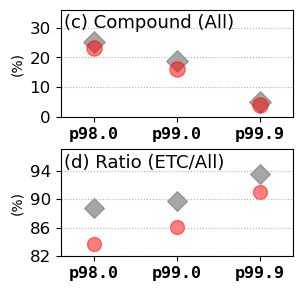

In [16]:
fig = plt.figure(figsize=(3.,3.2))
ax0 = fig.add_subplot(2, 1, 1)
xs=0.0
plt.scatter(0-xs,   CompAll_p98p0, s=120, c='gray', marker="D",alpha=0.7)
plt.scatter(0.2-xs, CompAll_p99p0, s=120, c='gray', marker="D",alpha=0.7)
plt.scatter(0.4-xs, CompAll_p99p9, s=120, c='gray', marker="D",alpha=0.7)
plt.scatter(0+xs,   CompAll_p98p0I, s=120, c='r', marker="o",alpha=0.5)
plt.scatter(0.2+xs, CompAll_p99p0I, s=120, c='r', marker="o",alpha=0.5)
plt.scatter(0.4+xs, CompAll_p99p9I, s=120, c='r', marker="o",alpha=0.5)
ax0.grid(axis='y',linestyle=':',zorder=0)
plt.xlim(-0.08,0.48)
plt.ylim(0, 36)
ax0.set_ylabel('(%)')
ax0.set_yticks([0,10,20,30])
ax0.set_yticklabels([0,10,20,30],fontsize=12)
ax0.set_xticks([0,0.2,0.4])
ax0.set_xticklabels(['p98.0','p99.0','p99.9'],rotation=0,ha='center',fontsize=12,**mono_font, weight='bold')

ax0.text(0.014,0.96,'(c) Compound (All)',
              horizontalalignment='left', verticalalignment='top',
              transform=ax0.transAxes,fontsize=13,zorder=28,**sans_font)



#ax2 = ax0.twinx()
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_ylim(87, 97)
plt.scatter(0-xs,   ETCratio_p98p0, s=100, c='gray', marker="D",alpha=0.7)
plt.scatter(0.2-xs, ETCratio_p99p0, s=100, c='gray', marker="D",alpha=0.7)
plt.scatter(0.4-xs, ETCratio_p99p9, s=100, c='gray', marker="D",alpha=0.7)
plt.scatter(0+xs,   ETCratio_p98p0I, s=100, c='r', marker="o",alpha=0.5)
plt.scatter(0.2+xs, ETCratio_p99p0I, s=100, c='r', marker="o",alpha=0.5)
plt.scatter(0.4+xs, ETCratio_p99p9I, s=100, c='r', marker="o",alpha=0.5)
ax2.set_ylabel('(%)')
plt.xlim(-0.08,0.48)
ax2.set_yticks([82,86,90,94])
ax2.set_yticklabels([82,86,90,94],fontsize=12)
ax2.set_xticks([0,0.2,0.4])
ax2.set_xticklabels(['p98.0','p99.0','p99.9'],rotation=0,ha='center',fontsize=12,**mono_font, weight='bold')
ax2.grid(axis='y',linestyle=':',zorder=0)

ax2.text(0.014,0.96,'(d) Ratio (ETC/All)',
              horizontalalignment='left', verticalalignment='top',
              transform=ax2.transAxes,fontsize=13,zorder=28,**sans_font)


plt.subplots_adjust(wspace=0, hspace=0.3)
plt.savefig('Fig5_cd_Frequency_ETCcompound_all_percentagea_IMERGadded', bbox_inches='tight', dpi=200)